# Image Denoising

We'll demonstrate the use of a typical encoder–decoder by denoising a very noisy brightfield image of a single particle.

## Simulate Data

We use `Deeptrack 2.0` to simulate a spherical particle.

In [2]:
import deeptrack as dt
import numpy as np

particle = dt.Sphere(
    position=np.array([0.5, 0.5]) * 64,
    z=0,
    position_unit="pixel",
    radius=50e-8,
    refractive_index=1.45 + 0.02j,
)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2023-12-15 17:48:53.563799: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.


We define the optical sysetm to image the particle.

### @Giovanni: In the original version we were providing examples about how to use DeepTrack for illumination gradient and coma, do we keep them? They are currently commented.

In [3]:
# illumination_gradient = dt.IlluminationGradient(
#     gradient=(0.01, 0.02),
#     constant=0.0,
# )

# aberr_coma = dt.HorizontalComa(
#     coefficient=1,
# )

spectrum = [500e-9]
brightfield_microscope = [
    dt.Brightfield(
        wavelength=wavelength,
        NA=1,
        resolution=1e-6,
        magnification=10,
        refractive_index_medium=1.33,
        upsample=2,
        output_region=(0, 0, 64, 64),
        # illumination=illumination_gradient,
        # pupil=aberr_coma,
    )
    for wavelength in spectrum
]

We create the sample by applying the optical system to the particle.

In [4]:
illuminated_sample = sum(
    [
        brightfield_microscope_onewl(particle)
        for brightfield_microscope_onewl in brightfield_microscope
    ]
)

We create a pipeline to simulate _clean_ particle images. We also corrupt them with some Poisson noise to have their noisy version. 

In [5]:
clean_particles = illuminated_sample >> dt.NormalizeMinMax()

noise = dt.Poisson(snr=lambda: 2.0 + np.random.rand() * 1)
noisy_particles = illuminated_sample >> noise >> dt.NormalizeMinMax()

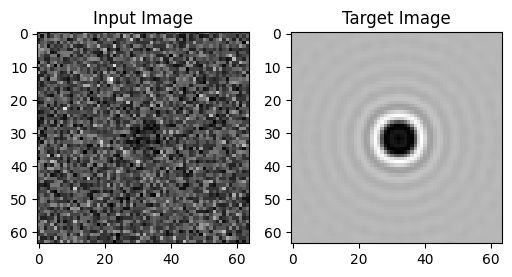

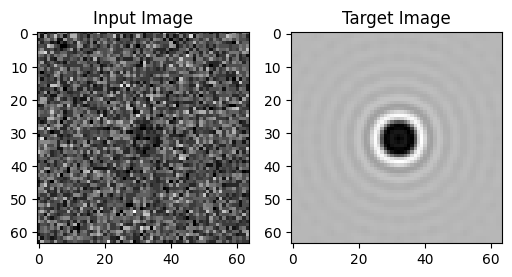

In [10]:
import matplotlib.pyplot as plt

for i in range(2):
    target = clean_particles.update()()
    input = noisy_particles.update()()
    plt.figure(figsize=(6, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input[..., 0], cmap="gray")
    plt.title("Input Image")
    plt.subplot(1, 2, 2)
    plt.imshow(target[..., 0], cmap="gray")
    plt.title("Target Image")

## @Giovanni: The next cell can be removed once Jesus merges the pull request to Deeptrack

In [15]:
from deeptrack.generators import ContinuousGenerator


class PyTorchContinuousGenerator(ContinuousGenerator):
    """Extends the ContinuousGenerator to support PyTorch models.

    This class is used to generate batches of data for PyTorch models."""

    def __init__(self, *args, flip=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.flip = flip

    def __getitem__(self, idx):
        import torch

        X, y = super().__getitem__(idx)

        if self.flip:
            X = np.transpose(X, (0, 3, 1, 2)) if len(X.shape) == 4 else X
            y = np.transpose(y, (0, 3, 1, 2)) if len(y.shape) == 4 else y

        return torch.from_numpy(X).to(torch.float), torch.from_numpy(y).to(torch.float)

We define a continuous generator to simulate images on the fly.
## @Giovanni: Uncomment the first line once the PR has been merged (and the previous cell removed)

In [17]:
# from deeptrack.generators import PyTorchContinuousGenerator

generator = PyTorchContinuousGenerator(
    (noisy_particles) & (clean_particles),
    batch_size=8,
    min_data_size=256,
    max_data_size=512,
)

## Autoencoder
We define the autoencoder architecture.

In [18]:
import deeplay as dl
from torch.nn import Sigmoid

autoencoder = dl.EncoderDecoder(
    in_channels=1,
    encoder_channels=[4, 8, 16],
    decoder_channels=[8, 4],
    out_channels=1,
    out_activation=Sigmoid,
)
print(autoencoder)

EncoderDecoder(
  (encoder_blocks): LayerList(
    (0): PoolLayerActivationNormalization(
      (pool): Layer[Identity]()
      (layer): Layer[Conv2d](in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=4)
    )
    (1): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Conv2d](in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=8)
    )
    (2): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Conv2d](in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=16)
    )
    (3): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Identity](num_f

We define the loss and the optimizer...

In [19]:
import torchmetrics as tm
from torch.nn import L1Loss


regressor_template = dl.Regressor(
    model=autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)

autoencoder_regressor = regressor_template.create()

... and start the training.

In [20]:
autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
with generator:
    autoencoder_trainer.fit(autoencoder_regressor, generator)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | EncoderDecoder   | 1.5 K 
5 | optimizer     | Adam             | 0     
---------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006   

Generating 267 / 256 samples before starting training


/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


We visualize the autoencoder predictions.

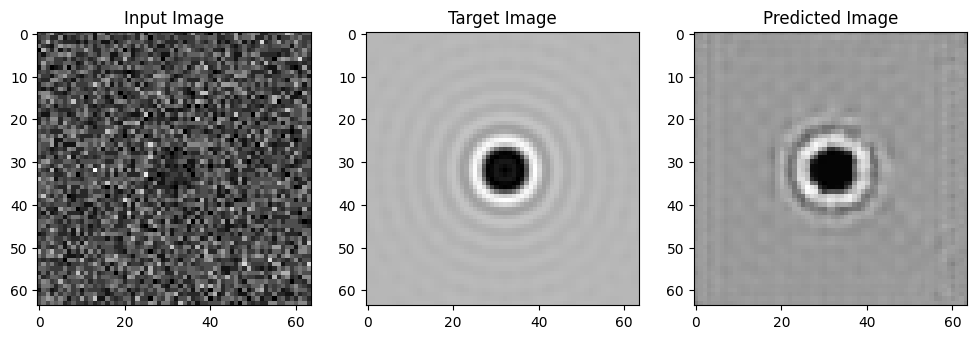

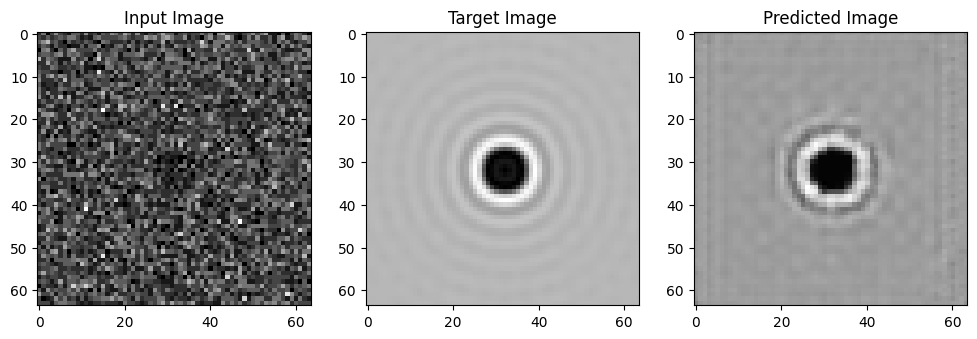

In [26]:
import matplotlib.pyplot as plt

input_im, target_im = next(iter(generator))
predicted_im = autoencoder_regressor(input_im).detach()
for i in range(2):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[i, 0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[i, 0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[i, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

The training images are very similar. It can be that the autoencoder just learn to provide a centered particle, no matter what is the input (mode collapse). Let's check it out by making a prediction out of noise. 

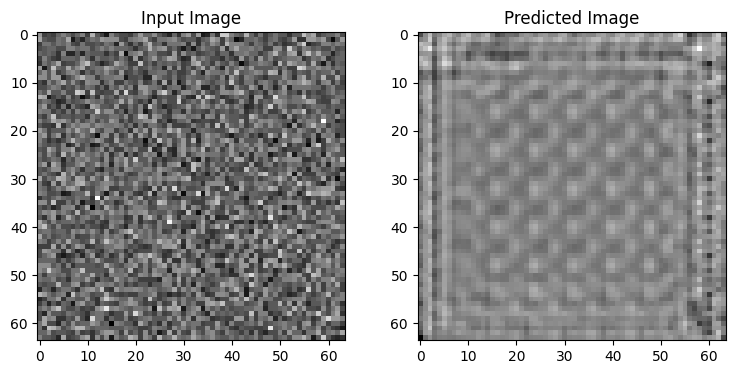

In [27]:
import torch

blank = sum(
    [
        brightfield_microscope_one_wl(particle ^ 0)
        for brightfield_microscope_one_wl in brightfield_microscope
    ]
)
blank_image = blank >> noise >> dt.NormalizeMinMax()
blank_image = blank_image.update().resolve().squeeze()
blank_image = torch.tensor(blank_image[np.newaxis, np.newaxis, :, :]).float()
predicted_image = autoencoder_regressor(blank_image).detach()
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(blank_image[0, 0, :, :], cmap="gray")
axs[0].set_title("Input Image")
axs[1].imshow(predicted_image[0, 0, :, :], cmap="gray")
axs[1].set_title("Predicted Image")
plt.show()

Let's see if the autoencoder is able to generalize its predictions to particles located off center and with different size.

In [29]:
new_particles = dt.Sphere(
    position=lambda: np.array([0.4, 0.4] + np.random.rand(2) * 0.2) * 64,
    z=0,
    position_unit="pixel",
    radius=lambda: 50e-8 + np.random.rand() * 50e-8,
    refractive_index=1.45 + 0.02j,
)

new_illuminated_sample = sum(
    [
        brightfield_microscope_onewl(new_particles)
        for brightfield_microscope_onewl in brightfield_microscope
    ]
)

new_clean_particles = new_illuminated_sample >> dt.NormalizeMinMax()
new_noisy_particles = new_illuminated_sample >> noise >> dt.NormalizeMinMax()

We check the predictions on this more challenging test set.

Generating 256 / 256 samples before starting training


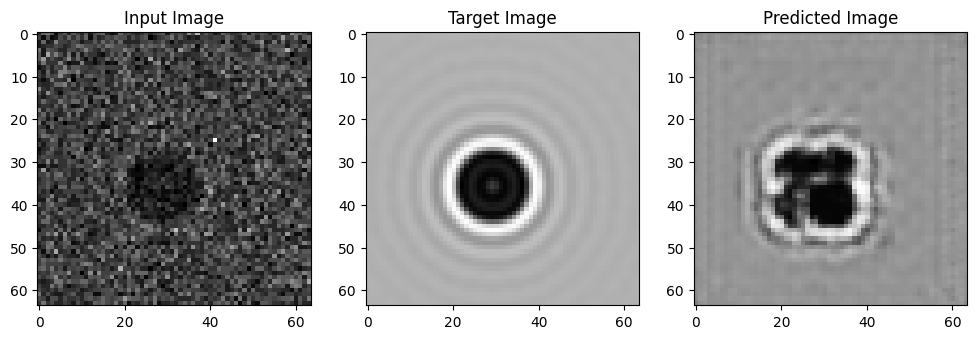

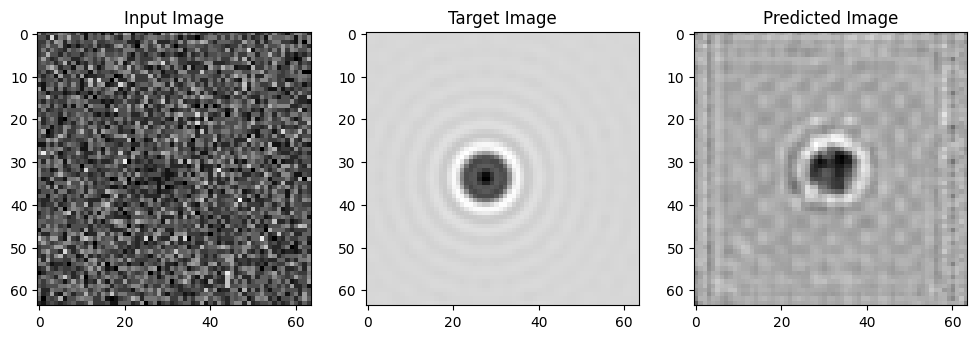

In [32]:
new_generator = PyTorchContinuousGenerator(
    (new_noisy_particles) & (new_clean_particles),
    batch_size=8,
    min_data_size=256,
    max_data_size=512,
)

with new_generator:
    input_im, target_im = next(iter(new_generator))
predicted_im = autoencoder_regressor(input_im).detach()
for i in range(2):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[i, 0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[i, 0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[i, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

We can train on the new dataset.

In [33]:
autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
with new_generator:
    autoencoder_trainer.fit(autoencoder_regressor, new_generator)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | EncoderDecoder   | 2.9 K 
5 | optimizer     | Adam             | 0     
---------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Generating 257 / 256 samples before starting training


/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


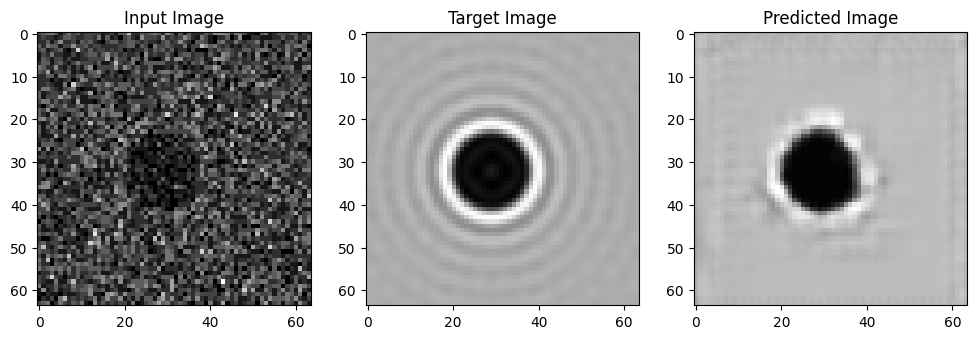

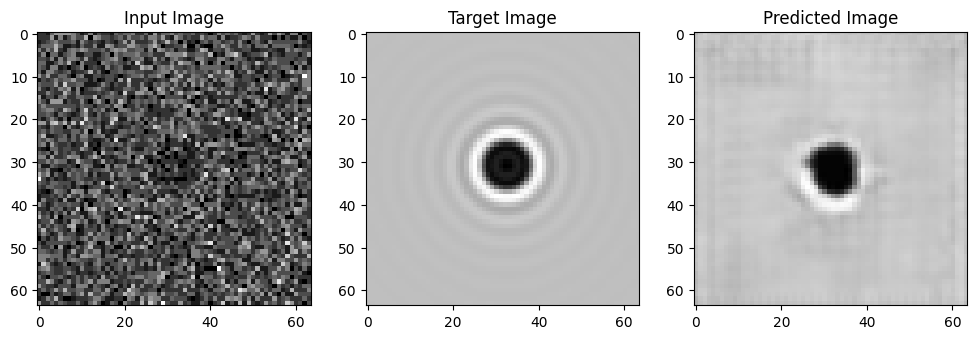

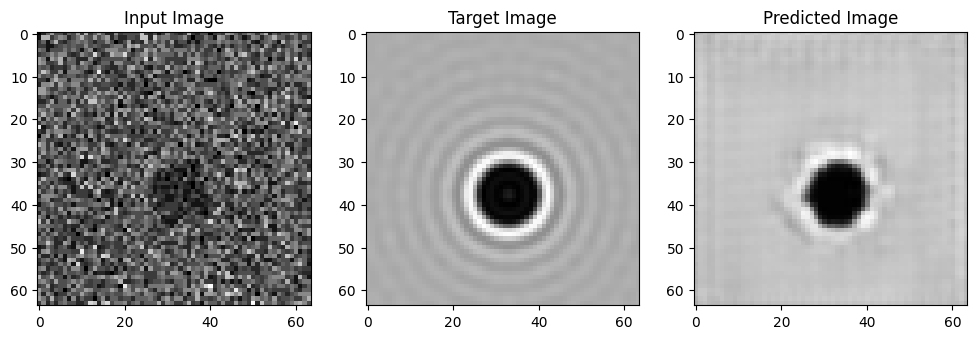

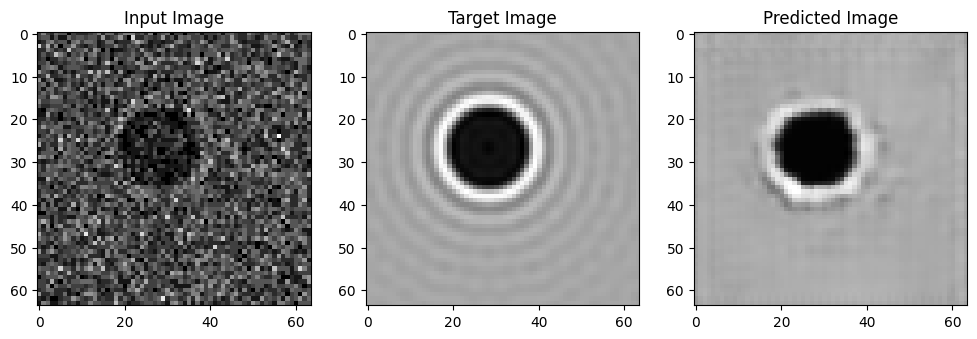

In [36]:
import matplotlib.pyplot as plt

input_im, target_im = next(iter(new_generator))
predicted_im = autoencoder_regressor(input_im).detach()
for i in range(4):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[i, 0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[i, 0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[i, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

## Improving the predictions
We can use a model with a larger number of activations to improve the results.

In [37]:
import deeplay as dl
from torch.nn import Sigmoid

better_autoencoder = dl.EncoderDecoder(
    in_channels=1,
    encoder_channels=[16, 32, 64],
    decoder_channels=[32, 16],
    out_channels=1,
    out_activation=Sigmoid,
)
print(better_autoencoder)

EncoderDecoder(
  (encoder_blocks): LayerList(
    (0): PoolLayerActivationNormalization(
      (pool): Layer[Identity]()
      (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=16)
    )
    (1): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=32)
    )
    (2): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=64)
    )
    (3): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Identity]

In [38]:
better_regressor_template = dl.Regressor(
    model=better_autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)

better_autoencoder_regressor = better_regressor_template.create()

better_autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
with new_generator:
    better_autoencoder_trainer.fit(better_autoencoder_regressor, new_generator)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | EncoderDecoder   | 23.3 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
23.3 K    Trainable params
0         Non-trainable params
23.3 K    Total params
0.093     Total estimated model params size (MB)


Generating 511 / 256 samples before starting training


/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


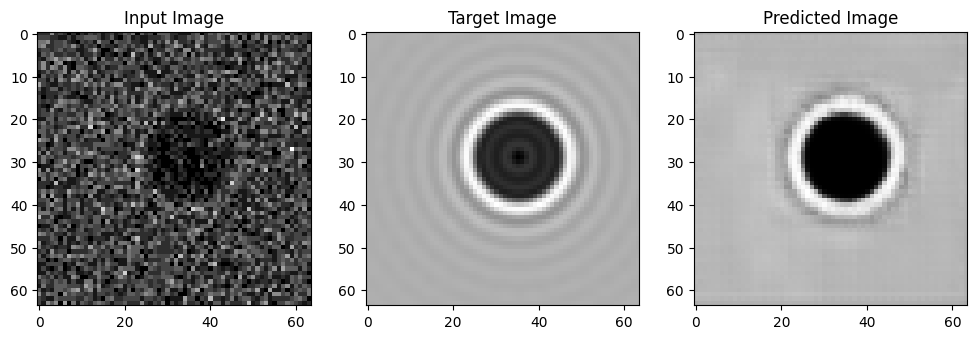

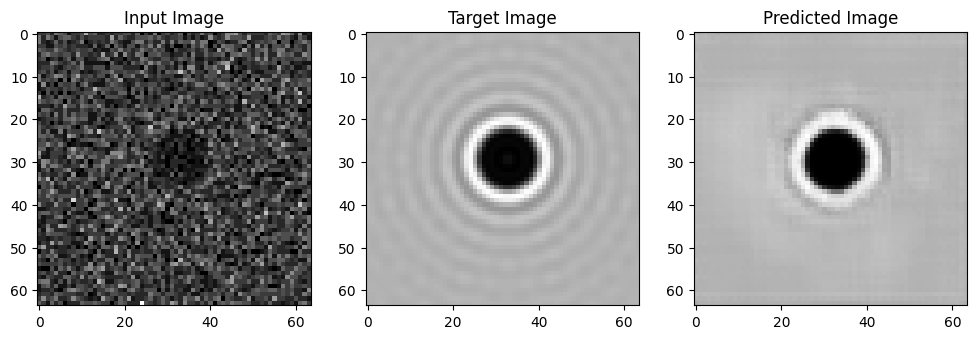

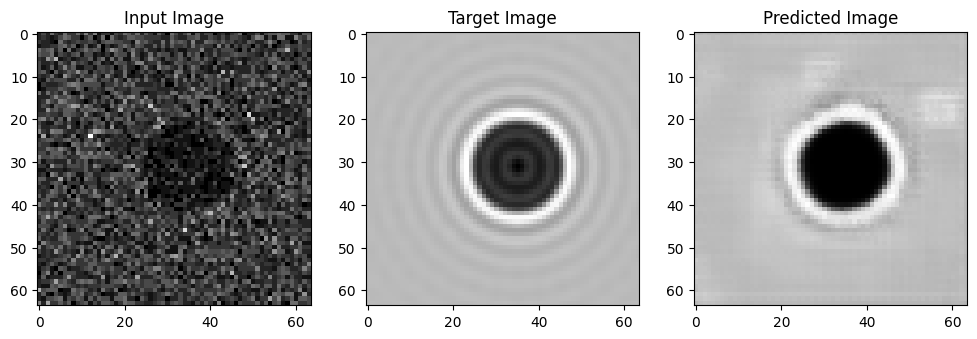

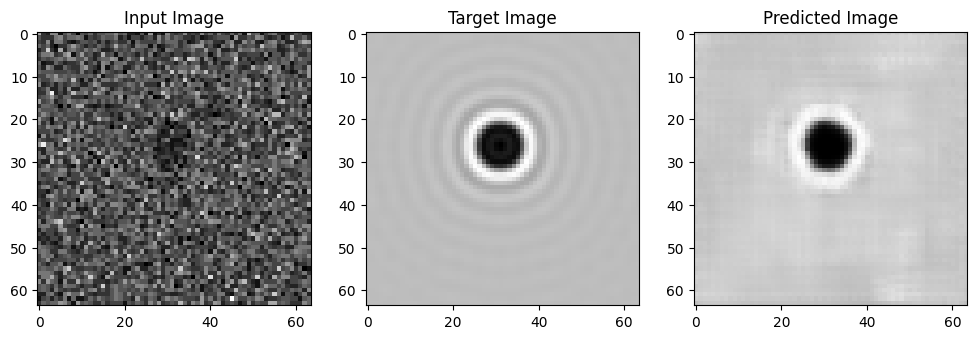

In [39]:
input_im, target_im = next(iter(new_generator))
predicted_im = better_autoencoder_regressor(input_im).detach()
for i in range(4):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[i, 0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[i, 0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[i, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

## @Giovanni: this would be an alternative way to do something similar

In [41]:
import torch
import deeplay as dl
from torch.nn import MaxPool2d, ReLU, Identity, Sigmoid, Upsample

encoder = dl.ConvolutionalNeuralNetwork(
    in_channels=1,
    hidden_channels=[16, 32, 64],
    out_channels=64,
    pool=MaxPool2d(kernel_size=2),
    out_activation=Identity,
)
encoder.blocks[-1].layer.configure(Identity)

bottleneck = dl.Layer(Identity)

decoder = dl.ConvolutionalNeuralNetwork(
    in_channels=64,
    hidden_channels=[32, 16],
    out_channels=1,
    pool=Upsample(scale_factor=2),
    out_activation=Sigmoid,
)
decoder.blocks[0].pool.configure(Upsample, scale_factor=2)
autoenc = dl.Sequential(encoder, bottleneck, decoder)

print(autoencoder)

regr_template = dl.Regressor(
    model=autoenc,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)

autoenc_regressor = regr_template.create()


autoenc_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
with new_generator:
    autoenc_trainer.fit(autoenc_regressor, new_generator)

EncoderDecoder(
  (encoder_blocks): LayerList(
    (0): PoolLayerActivationNormalization(
      (pool): Layer[Identity]()
      (layer): Layer[Conv2d](in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=4)
    )
    (1): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Conv2d](in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=8)
    )
    (2): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Conv2d](in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=16)
    )
    (3): PoolLayerActivationNormalization(
      (pool): Layer[MaxPool2d](kernel_size=2)
      (layer): Layer[Identity](num_f

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 46.5 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
46.5 K    Trainable params
0         Non-trainable params
46.5 K    Total params
0.186     Total estimated model params size (MB)


Generating 511 / 256 samples before starting training


Training: |          | 0/? [00:00<?, ?it/s]

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
